# LLM Inference Pipeline

This notebook implements the LLM inference pipeline described in `pipeline_spec.md`.

Sections:
- Setup & installs
- Parse and validate spec
- Tokenizer & Model loader
- Prompt construction
- Dataset loading & sampling
- Batched inference & streaming generator
- Extraction, metrics, and plotting
- Demo runs and simple tests


In [20]:
# Setup: Install dependencies and import packages

# If running in binder or a fresh environment you may need to install packages.
# Use `%pip install` to ensure installs are available in the notebook kernel.

# Uncomment and run if you need to install packages
# %pip install -q transformers accelerate torch pandas matplotlib seaborn datasets evaluate tqdm regex sentencepiece

import os
import json
import re
from dataclasses import dataclass, asdict
from typing import List, Optional, Dict, Any, Tuple
import logging
import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Try importing transformers and torch and give friendly guidance if missing
try:
    import torch
    from transformers import (
        AutoTokenizer,
        AutoModelForCausalLM,
        pipeline,
        logging as hf_logging,
    )
except Exception as e:
    raise RuntimeError(
        "Transformers or Torch not available in the kernel. Please run the install cell: `%pip install transformers torch`"
    ) from e

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
hf_logging.set_verbosity_error()

# Device detection
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.mps.is_available() else "cpu"
)
logger.info(f"Using device: {DEVICE}")

# Reproducible seeds
DEFAULT_SEED = 42
random.seed(DEFAULT_SEED)
torch.manual_seed(DEFAULT_SEED)

# Default paths / constants
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "datasets"
PIPELINE_SPEC = PROJECT_ROOT / "pipeline_spec.md"
DEFAULT_MODEL = (
    "Qwen/Qwen2.5-0.5B-Instruct"  # per spec; we will fallback if unavailable
)

In [21]:
import os

try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_PATH = '/content/gdrive/My Drive/cs263'  # No need for backslash
    if not os.path.exists(DRIVE_PATH):
        !mkdir -p "$DRIVE_PATH"  # Ensure the folder exists

    # Create a symlink to avoid issues with spaces in 'My Drive'
    SYM_PATH = '/content/cs263'
    if not os.path.exists(SYM_PATH):
        !ln -s "$DRIVE_PATH" "$SYM_PATH"

    running_in_colab = True
    
    # We already mounted in our google drive.
    # Enter the foler where you put files in:
    %cd '/content/cs263'

except ModuleNotFoundError:
    running_in_colab = False
    print("I guess you are running locally. If you get this message in Colab, something is wrong.")


print("\nCurrent working directory:")
!pwd

print("\nWhat files are there:")
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/cs263

Current working directory:
/content/gdrive/My Drive/cs263

What files are there:
datasets


In [22]:
@dataclass
class PipelineSpec:
    default_model: str = DEFAULT_MODEL
    tokenizer_context_length: int = 2048
    classification_system_prompt: str = (
        "You are a news trustworthiness classifier.\n"
        "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
        "Your answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\n"
    )
    user_template: str = "ARTICLE: {article}"


pipeline_spec = PipelineSpec()

In [23]:
# Cache util
class SimpleCache:
    def __init__(self):
        self._cache = {}

    def get(self, key):
        return self._cache.get(key)

    def set(self, key, value):
        self._cache[key] = value


cache = SimpleCache()

In [24]:
# Model loader: device placement, caching, and smoke tests


def load_model(
    model_name: str, device: str = DEVICE, dtype: Optional[torch.dtype] = None
):
    """Load a causal LM model with graceful fallback.

    Returns: (model, tokenizer)
    """
    # Check cache
    cache_key = f"model::{model_name}::device::{device}"
    cached_model = cache.get(cache_key)
    if cached_model is not None:
        logger.info(f"Using cached model for {model_name}")
        return cached_model

    try:
        model = AutoModelForCausalLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        # Add pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<|pad|>"})
            model.resize_token_embeddings(len(tokenizer))
        model.to(device)
        model.eval()
        cache.set(cache_key, (model, tokenizer))
        logger.info(f"Loaded model {model_name} to {device}")
        return model, tokenizer
    except Exception as e:
        logger.warning(f"Failed to load model {model_name}: {e}")
        raise


model, tokenizer = load_model(pipeline_spec.default_model)

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

In [25]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [26]:
# Prompt templates and preprocessing

SYSTEM_PROMPT = pipeline_spec.classification_system_prompt
USER_TEMPLATE = pipeline_spec.user_template


def make_prompts(
    articles: list[str] | pd.Series,
    system: str = SYSTEM_PROMPT,
    user_template: str = USER_TEMPLATE,
    prefilled=False,
) -> list[list[dict[str, str]]]:
    """
    Given a batch of articles (a list), returns a batch of formatted prompts.
    Each prompt is a list of dicts.
    Each dict contains role and content information.
    The system prompt contains generic classification instructions.
    The user content contains the article to be classified.
    Optionally, we prefill the model response to guide classification output.
    """
    # check that the articles are of the right type
    if type(articles) is not list and type(articles) is not pd.Series:
        raise ValueError(
            f"`articles` needs to be a list of strings. Got {type(articles)} instead."
        )

    messages_batch = []
    for article in articles:
        user_text = user_template.format(article=article)
        messages = [
            # {"role": "system", "content": system},
            {
                "role": "user",
                "content": system + user_text + "\n CLASSIFICATION (0 or 1):",
            },
        ]
        if prefilled:
            messages.append(
                {"role": "assistant", "content": "CLASSIFICATION (0 or 1):"},
            )
        messages_batch.append(messages)
    return messages_batch


def encode_prompts(prompts: list[list[dict[str, str]]], tokenizer):
    """
    Given a batch of formatted prompts, returns a batch of tokenized prompts.
    """
    prompts = [
        tokenizer.apply_chat_template(p, tokenize=False, add_generation_prompt=True)
        for p in prompts
    ]
    return tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )


def display_prompt(prompts: list[dict]) -> None:
    """
    Given a batch of (untokenized) prompts, pretty prints the first one.
    """
    for line in prompts[0]:
        for k, v in line.items():
            print(f"[{k}]: {v}")


# Example
prompts = ["This is a prompt."]
display_prompt(make_prompts(prompts, prefilled=True))

[role]: user
[content]: You are a news trustworthiness classifier.
Your task is to classify news articles as either trustworthy or untrustworthy.
Your answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.

ARTICLE: This is a prompt.
 CLASSIFICATION (0 or 1):
[role]: assistant
[content]: CLASSIFICATION (0 or 1):


In [27]:
# Dataset loader, sampling, and a small demo dataset
def load_dataset(
    data_dir: Path = DATA_DIR, max_rows: Optional[int] = None, use_seed=True
) -> pd.DataFrame:
    """
    Load dataset by combining `fake.csv` (label 0) and `true.csv` (label 1).
    Returns dataframe with columns "article" and "label".

    Now performs BALANCED sampling across classes.
    """
    fake_path = data_dir / "fake.csv"
    true_path = data_dir / "true.csv"

    rng = DEFAULT_SEED if use_seed else None

    if fake_path.exists() and true_path.exists():
        try:
            fake = pd.read_csv(fake_path)
            true = pd.read_csv(true_path)

            # Try to find an `article` column; fallback to first column
            def get_text_col(df):
                for c in ["article", "text", "content"]:
                    if c in df.columns:
                        return df[c].astype(str)
                return df.iloc[:, 0].astype(str)

            fake_df = pd.DataFrame({"article": get_text_col(fake), "label": 0})
            true_df = pd.DataFrame({"article": get_text_col(true), "label": 1})
            # Determine per-class sample size
            if max_rows is not None:
                per_class = max_rows // 2
            else:
                # take min class size for balance
                per_class = min(len(fake_df), len(true_df))

            # Sample independently from each class
            fake_df = fake_df.sample(
                n=min(per_class, len(fake_df)),
                random_state=rng,
            )

            true_df = true_df.sample(
                n=min(per_class, len(true_df)),
                random_state=rng,
            )

            # Merge + shuffle to avoid label ordering artifacts
            df = pd.concat([fake_df, true_df], ignore_index=True)
            df = df.sample(frac=1.0, random_state=rng).reset_index(drop=True)

            return df

        except Exception as e:
            logger.warning(f"Failed to read CSVs: {e}")

    # Fallback synthetic dataset
    logger.info("Using synthetic demo dataset (small).")
    demo = [
        (
            "Government releases new public health guidelines that are consistent with prior research and expert consensus.",
            1,
        ),
        (
            "Aliens landed on the White House lawn last night, multiple sources confirm",
            0,
        ),
        (
            "Scientific team publishes peer-reviewed article showing new vaccine efficacy.",
            1,
        ),
        (
            "Miracle cure for diabetes discovered in backyard herb; no clinical trials yet",
            0,
        ),
    ]
    df = pd.DataFrame(demo, columns=["article", "label"])

    if max_rows:
        df = df.head(max_rows)

    return df


def sample_k(
    df: pd.DataFrame, k: int, mode: str = "random", seed: Optional[int] = None
) -> pd.DataFrame:
    if seed is None:
        seed = DEFAULT_SEED
    if mode == "random":
        return df.sample(n=min(k, len(df)), random_state=seed).reset_index(drop=True)
    elif mode == "first":
        return df.head(k).reset_index(drop=True)
    else:
        raise ValueError("mode must be 'random' or 'first'")


# Quick demo load
dataset = load_dataset()
samples = sample_k(dataset, k=100)
samples.head()

,article,label
0,(Reuters) - A populist politician whose party ...,1
1,After examining the data Reuters used to make ...,0
2,SHANGHAI (Reuters) - Chinese state media warne...,1
3,NAIROBI (Reuters) - Kenyan police fired tearga...,1
4,This is great and so wonderful to see the posi...,0


### Test tokenizer on prompts

In [28]:
messages = make_prompts(dataset["article"].iloc[:3], prefilled=True)
prompts = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
try:
    tok_ids = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )
    logger.info("Successfully tokenized prompt")
except Exception as e:
    logger.warning("Failed to tokenize prompt")
messages

[[{'role': 'user',
   'content': 'You are a news trustworthiness classifier.\nYour task is to classify news articles as either trustworthy or untrustworthy.\nYour answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\nARTICLE:  \n CLASSIFICATION (0 or 1):'},
  {'role': 'assistant', 'content': 'CLASSIFICATION (0 or 1):'}],
 [{'role': 'user',
   'content': 'You are a news trustworthiness classifier.\nYour task is to classify news articles as either trustworthy or untrustworthy.\nYour answer should consist of exactly one token: 0 if the article is untrustworthy and 1 if it is trustworthy.\n\nARTICLE: MILWAUKEE (Reuters) - U.S. House of Representatives Speaker Paul Ryan handily won a primary election for his congressional seat on Tuesday, a contest overshadowed by presidential candidate Donald Trump’s brief refusal last week to endorse his fellow Republican.  Ryan, who ran unsuccessfully for vice president in 2012, had roughly 84 percen

### Generate Predictions

In [29]:
# Batched synchronous generation and streaming demo


def generate_batch(
    model,
    tokenizer,
    prompts: list[list[dict[str, str]]],
    max_new_tokens: int = 32,
    temperature: float = 0.0,
    do_sample: bool = False,
    batch_size: int = 4,
) -> tuple[list[str], list[str]]:
    outputs = []
    raw_outputs = []
    model_device = next(model.parameters()).device
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i : i + batch_size]
        batch_prompts = tokenizer.apply_chat_template(
            batch_prompts,
            tokenize=False,
            add_generation_prompt=True,
        )
        enc = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        # compute prompt lengths (number of non-padded tokens) from attention mask
        prompt_lengths = enc.attention_mask.sum(dim=1).tolist()

        # move tensors to device
        input_ids = enc.input_ids.to(model_device)
        attention_mask = enc.attention_mask.to(model_device)

        # generate
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=do_sample,
                temperature=temperature,
                pad_token_id=tokenizer.pad_token_id,
            )

        # For each generated sequence, decode only the generated portion using prompt_lengths
        for idx in range(generated_ids.size(0)):
            ids = generated_ids[idx]
            prompt_len = int(prompt_lengths[idx])
            # slice off the prompt tokens to get only the newly generated tokens
            response_ids = ids[prompt_len:]
            raw_text = tokenizer.decode(response_ids, skip_special_tokens=True)
            processed_text = remove_thinking(raw_text)
            outputs.append(processed_text)
            raw_outputs.append(raw_text)
    return outputs, raw_outputs


def remove_thinking(text):
    if "<think>" not in text:
        return text
    if "</think>" not in text:
        return None
    return text.split("</think>")[1]


# Extract classification labels


def extract_classification(text: str) -> Optional[int]:
    if not isinstance(text, str):
        return None
    # Try to find an explicit 0/1 token
    m = re.search(r"\b([01])\b", text)
    if m:
        return int(m.group(1))
    # Try to find words
    txt = text.lower()
    if "untrust" in txt or "fake" in txt or "not" in txt and "trust" in txt:
        return 0
    if "trust" in txt or "true" in txt or "reliable" in txt:
        return 1
    return None


# Demo of extraction
tests = ["0", "1", "The answer is 0.", "Trustworthy", "This seems fake."]
for t in tests:
    print(t, "->", extract_classification(t))

0 -> 0
1 -> 1
The answer is 0. -> 0
Trustworthy -> 1
This seems fake. -> 0


### Test generation

In [30]:
articles = samples["article"].iloc[:3]
messages = make_prompts(articles)
processed_messages = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
enc = tokenizer(
    processed_messages,
    return_tensors="pt",
    padding=True,
    truncation=True,
)
prompts = make_prompts(articles)
prompts[0]
generate_batch(
    model,
    tokenizer,
    prompts,
)

(['Human: 1', '1', 'Human: 1'], ['Human: 1', '1', 'Human: 1'])

Accuracy: 0.75


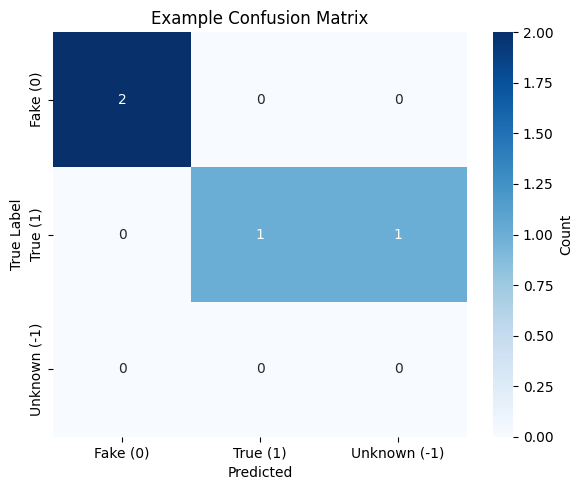

In [31]:
# Metrics and plotting

from sklearn.metrics import accuracy_score, confusion_matrix


def compute_metrics(y_true: List[int], y_pred: List[Optional[int]]) -> Dict[str, Any]:
    # Convert None to a special class or treat as incorrect
    y_pred_clean = [(p if p is not None else -1) for p in y_pred]
    # For accuracy, treat None as incorrect
    valid_mask = [p in (0, 1) for p in y_pred]
    acc = accuracy_score(y_true, [p if p in (0, 1) else -1 for p in y_pred_clean])
    cm = confusion_matrix(
        y_true, [p if p in (0, 1) else 2 for p in y_pred_clean], labels=[0, 1, 2]
    )
    return {"accuracy": acc, "confusion_matrix": cm}


def plot_confusion_matrix(cm, title: str = "Confusion Matrix"):
    """Display confusion matrix as a seaborn heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        yticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        cbar_kws={"label": "Count"},
    )
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()


def plot_metric_comparison(metrics_by_model: Dict[str, Dict[str, Any]]):
    df = pd.DataFrame(
        [
            {"model": m, "accuracy": metrics["accuracy"]}
            for m, metrics in metrics_by_model.items()
        ]
    )
    sns.barplot(data=df, x="model", y="accuracy")
    plt.ylim(0, 1)
    plt.title("Model accuracy comparison")


# Example usage with dummy preds
metrics = compute_metrics([1, 0, 1, 0], [1, 0, None, 0])
print(f"Accuracy: {metrics['accuracy']}")
plot_confusion_matrix(metrics["confusion_matrix"], "Example Confusion Matrix")

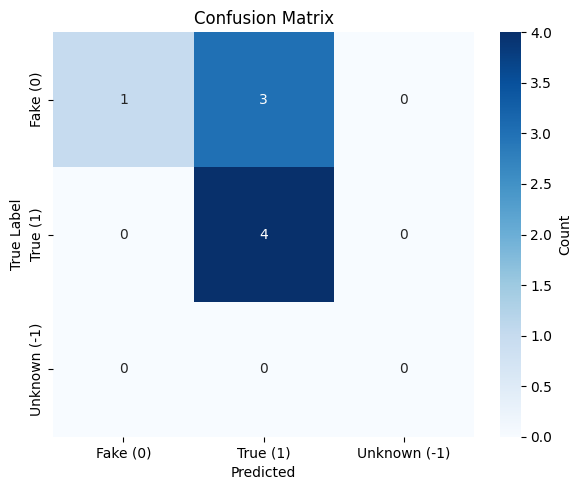

In [32]:
# Full pipeline runner for a model name (small, non-optimized demo)


def run_pipeline_on_dataset(
    model_name: str,
    df: pd.DataFrame,
    k: int = 20,
    max_new_tokens: int = 200,
    sample_mode: str = "random",
    seed: Optional[int] = None,
):
    model, tokenizer = load_model(model_name)
    samples = sample_k(df, k=k, mode=sample_mode, seed=seed)
    prompts = make_prompts(samples.article.tolist())
    outputs, raw_outputs = generate_batch(
        model, tokenizer, prompts, max_new_tokens=max_new_tokens, batch_size=4
    )
    preds = [extract_classification(o) for o in outputs]
    metrics = compute_metrics(samples.label.tolist(), preds)
    return {
        "model": model_name,
        "metrics": metrics,
        "preds": preds,
        "prompts": prompts,
        "outputs": outputs,
        "raw_outputs": raw_outputs,
        "labels": samples.label.tolist(),
    }


demo_res = run_pipeline_on_dataset(pipeline_spec.default_model, dataset, k=8)
plot_confusion_matrix(demo_res["metrics"]["confusion_matrix"])

# Model comparison

The next cell contains a model list; please add to it any model we want to compare. The cell will run `run_pipeline_on_dataset` with the specified models and store the results in a `results` dict (with model names as keys).

In [34]:
model_list = [
    # "Qwen/Qwen2.5-0.5B-Instruct",
    # "Qwen/Qwen2.5-1.5B-Instruct",
    # "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B"
]
NUM_SAMPLES = 10
results = {}
for model in model_list:
    # Use the model name as the dict key so multiple models are stored separately
    results[model] = run_pipeline_on_dataset(model, dataset, k=NUM_SAMPLES)

In [35]:
def compare_model_results(results: Dict[str, Dict[str, Any]]) -> None:
    """
    Compare accuracies across multiple model runs.

    Args:
        results: Dictionary mapping model names to results from run_pipeline_on_dataset.
                 Each result should have a 'metrics' key containing 'accuracy'.
    """
    # Extract accuracies
    comparison_data = []
    for model_name, result in results.items():
        accuracy = result["metrics"]["accuracy"]
        comparison_data.append({"model": model_name, "accuracy": accuracy})

    df = pd.DataFrame(comparison_data)

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="model", y="accuracy", palette="Set2")
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nAccuracy Summary:")
    print(df.to_string(index=False))
    print(
        f"\nBest model: {df.loc[df['accuracy'].idxmax(), 'model']} ({df['accuracy'].max():.4f})"
    )

/tmp/ipython-input-520495271.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y="accuracy", palette="Set2")


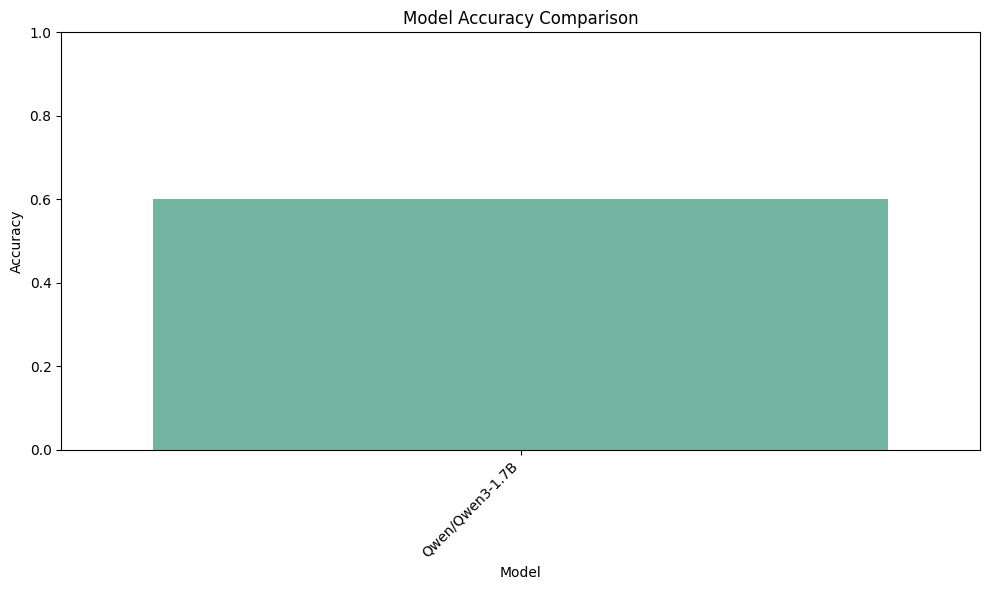


Accuracy Summary:
          model  accuracy
Qwen/Qwen3-1.7B       0.6

Best model: Qwen/Qwen3-1.7B (0.6000)


In [36]:
compare_model_results(results)
# print(results)

In [37]:
# debug
for model_name, result in results.items():
    print(f"\n=== {model_name} ===")
    for i, (prompt, out, raw_output, pred, l) in enumerate(
        zip(
            result["prompts"][:10],
            result["outputs"][:10],
            result["raw_outputs"][:10],
            result["preds"][:10],
            result["labels"][:10],
        )
    ):
        print(f" Raw output: {raw_output}")
        print(f" Processed Output: {out} -> Pred: {pred}; Label: {l}\n")


=== Qwen/Qwen3-1.7B ===
 Raw output: 
<think>
</think>

1
 Processed Output: 

1 -> Pred: 1; Label: 1

 Raw output: <think>
Okay, let's try to figure out if this article is trustworthy or not. The user wants a classification of 0 (untrustworthy) or 1 (trustworthy). 

First, I need to understand the content of the article. The article starts by mentioning Reuters and their previous prediction about Democrats allowing illegal aliens to vote in 2016. Then it talks about a study that claims elections are predictable based on certain factors. The author uses a model that looks at past election data, including approval ratings and incumbency, to predict outcomes.

The article mentions that polls are often misleading, with errors increasing as the election approaches. It also provides a table with data on poll errors over time. The model is based on probabilities and party-level data, not individual candidates. The conclusion is that a Republican will win in 2017, but the article also notes 

- Improve COT thinking where you reduce length of COT - and making sure it finished COT before using the prediction - split of </think> and taking RHS.
- Prompt engineering to improve base numbers
- Different families of models